<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [ ]:
# Загрузим файл taxi.csv
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [ ]:
display(df.info())
display(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

num_orders    0
dtype: int64

In [ ]:
display(df.head(5))
display(df.tail(5))

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


Уменьшим частоту выборки до 1 часа

In [ ]:
df = df.resample('1H').sum()
display(df.head(5))

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

Для анализа данных выведем основные статистические характеристики и построим графики:

        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


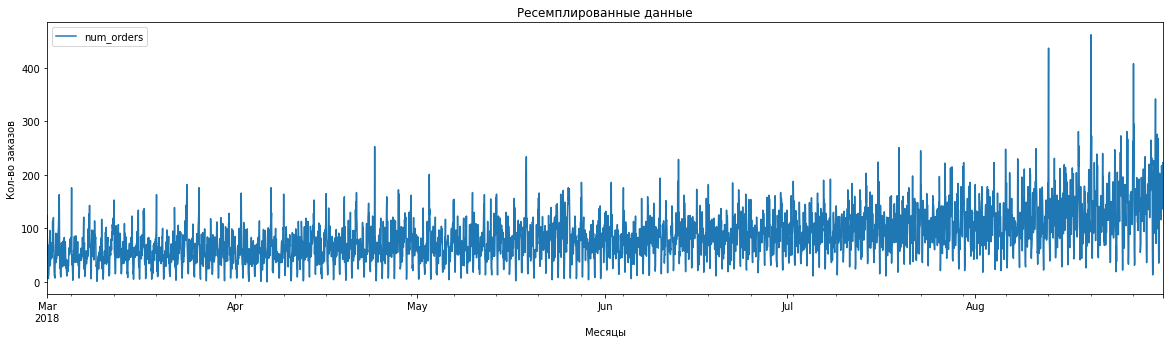

In [ ]:
print(df.describe())

figsize = (20,5)

df.plot(figsize=figsize)
plt.title('Ресемплированные данные')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

На графике видно, что количество заказов увеличивается со временем. Также заметны сезонные колебания в течение суток и небольшой тренд на увеличение заказов с марта по август 2018 года.

Рассмотрим более детально последние данные

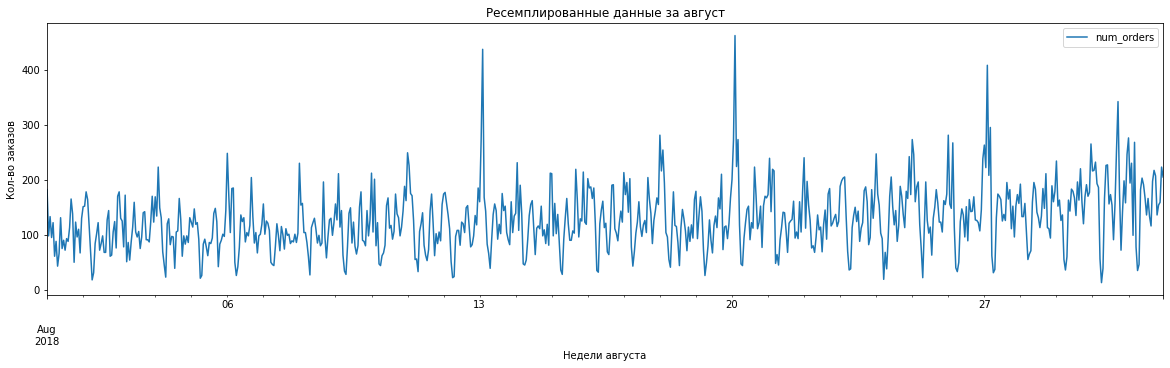

In [ ]:
# За август:
df_2018_08 = df['2018-08-01':]
df_2018_08.plot(figsize=figsize)
plt.title('Ресемплированные данные за август')
plt.xlabel('Недели августа')
plt.ylabel('Кол-во заказов')
plt.show()

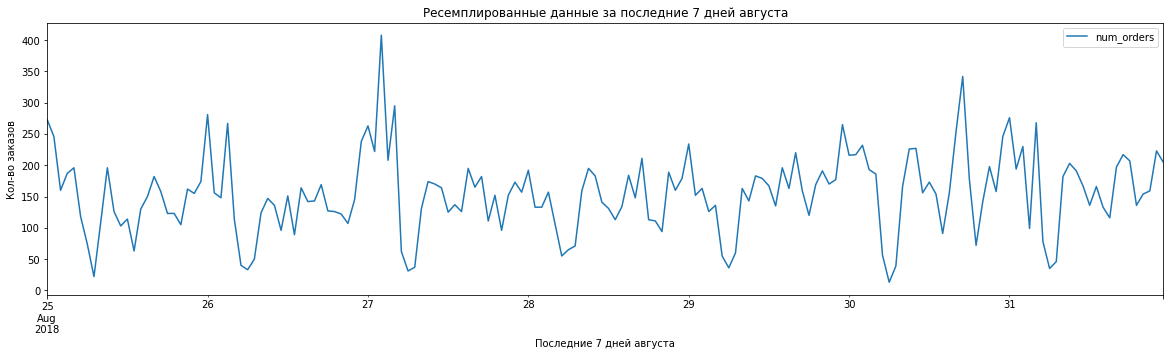

In [ ]:
# За последние 7 дней августа:
df_2018_08_7days = df['2018-08-25':]
df_2018_08_7days.plot(figsize=figsize)
plt.title('Ресемплированные данные за последние 7 дней августа')
plt.xlabel('Последние 7 дней августа')
plt.ylabel('Кол-во заказов')
plt.show()

Отчетливо видны всплески в количестве заказов в полуночное время и в середине рабочего дня. По утрам наибольшая просадка

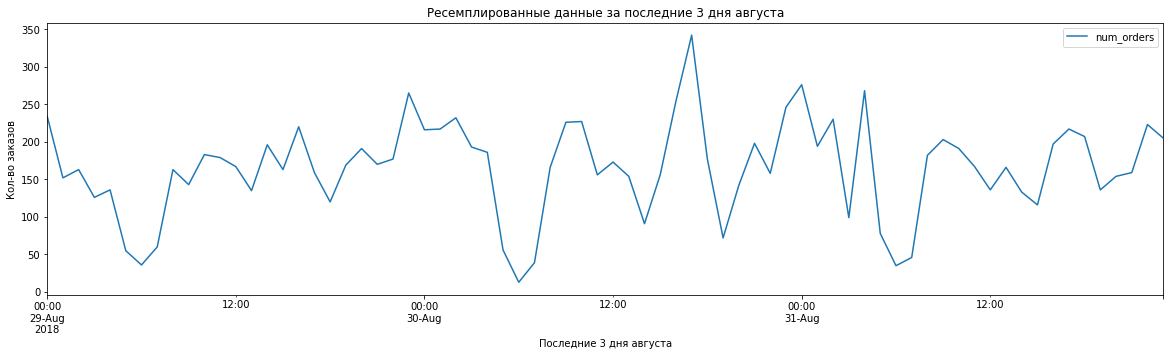

In [ ]:
# График за последние 3 дня августа:
df_2018_08_3days = df['2018-08-29':]
df_2018_08_3days.plot(figsize=figsize)
plt.title('Ресемплированные данные за последние 3 дня августа')
plt.xlabel('Последние 3 дня августа')
plt.ylabel('Кол-во заказов')
plt.show()

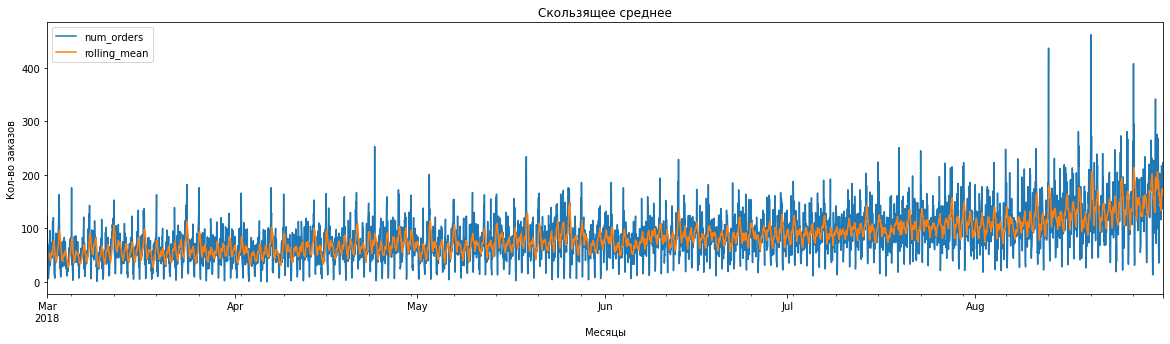

In [ ]:
# Скользящее среднее
df['rolling_mean'] = df.rolling(10).mean()
df.plot(figsize=figsize)
plt.title('Скользящее среднее')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

/tmp/ipykernel_121/2184090901.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018_08['rolling_mean'] = df_2018_08.rolling(10).mean()


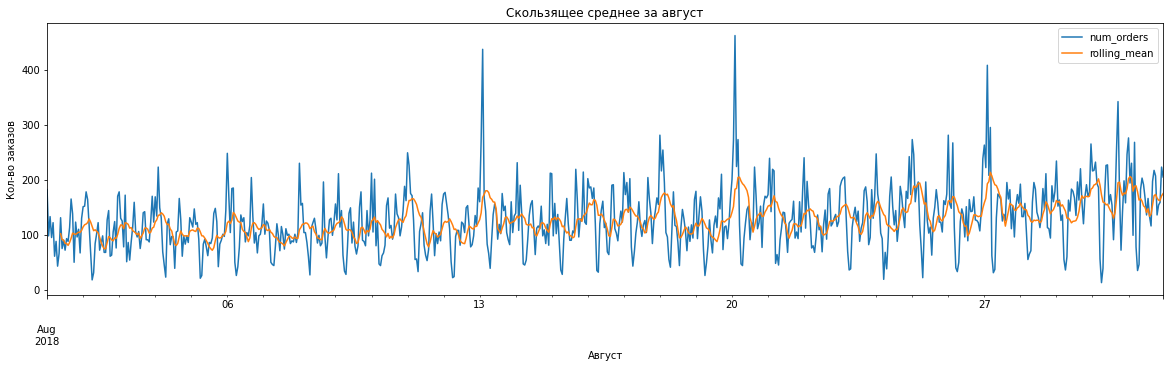

In [ ]:
# Скользящее среднее за август
df_2018_08['rolling_mean'] = df_2018_08.rolling(10).mean()
df_2018_08.plot(figsize=figsize)
plt.title('Скользящее среднее за август')
plt.xlabel('Август')
plt.ylabel('Кол-во заказов')
plt.show()

/tmp/ipykernel_121/682852316.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018_08_7days['rolling_mean'] = df_2018_08_7days.rolling(10).mean()


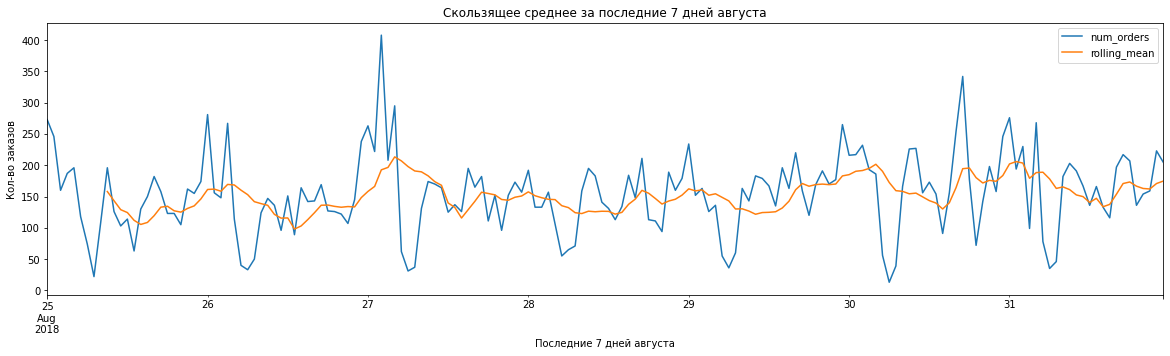

In [ ]:
# Скользящее среднее за 7 дней августа
df_2018_08_7days['rolling_mean'] = df_2018_08_7days.rolling(10).mean()
df_2018_08_7days.plot(figsize=figsize)
plt.title('Скользящее среднее за последние 7 дней августа')
plt.xlabel('Последние 7 дней августа')
plt.ylabel('Кол-во заказов')
plt.show()

/tmp/ipykernel_121/49704652.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018_08_3days['rolling_mean'] = df_2018_08_3days.rolling(10).mean()


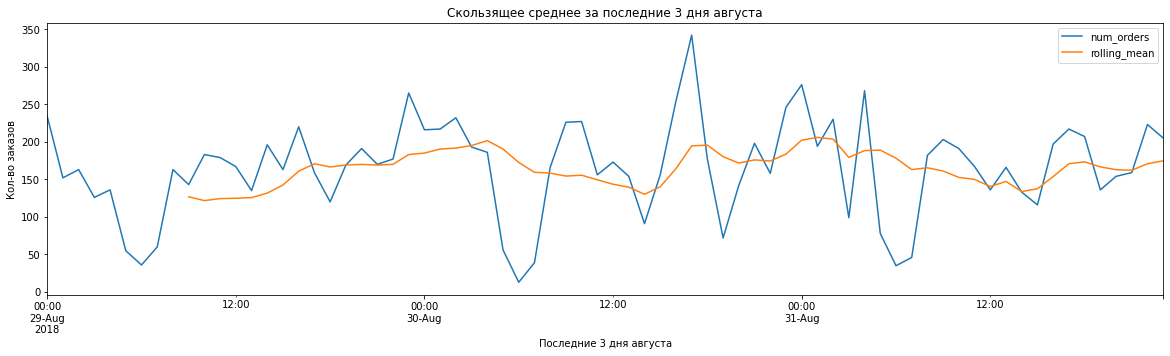

In [ ]:
# Скользящее среднее за 3 дня августа
df_2018_08_3days['rolling_mean'] = df_2018_08_3days.rolling(10).mean()
df_2018_08_3days.plot(figsize=figsize)
plt.title('Скользящее среднее за последние 3 дня августа')
plt.xlabel('Последние 3 дня августа')
plt.ylabel('Кол-во заказов')
plt.show()

In [ ]:
# Декомпозирую данные:
decomposed = seasonal_decompose(df.num_orders)
decomposed_aug = seasonal_decompose(df_2018_08.num_orders)
decomposed_aug_3days = seasonal_decompose(df_2018_08_3days.num_orders)

**Тренды: весь период, последний месяц, последние 3 дня**

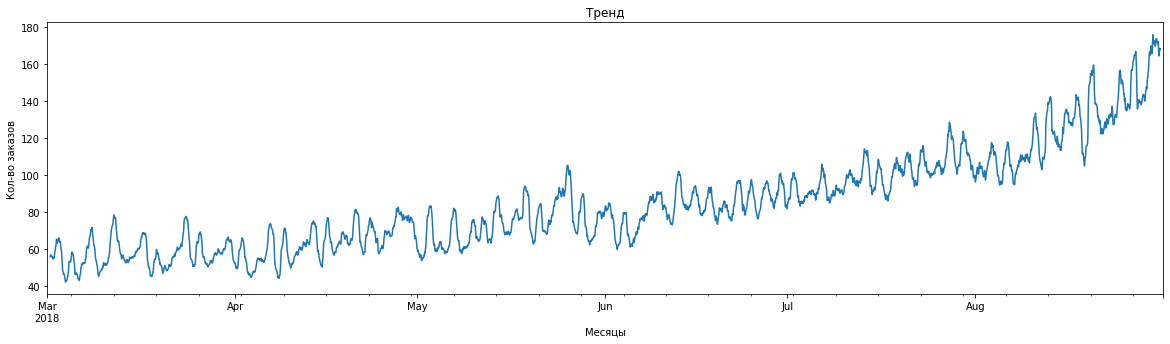

In [ ]:
decomposed.trend.plot(figsize=figsize)
plt.title('Тренд')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

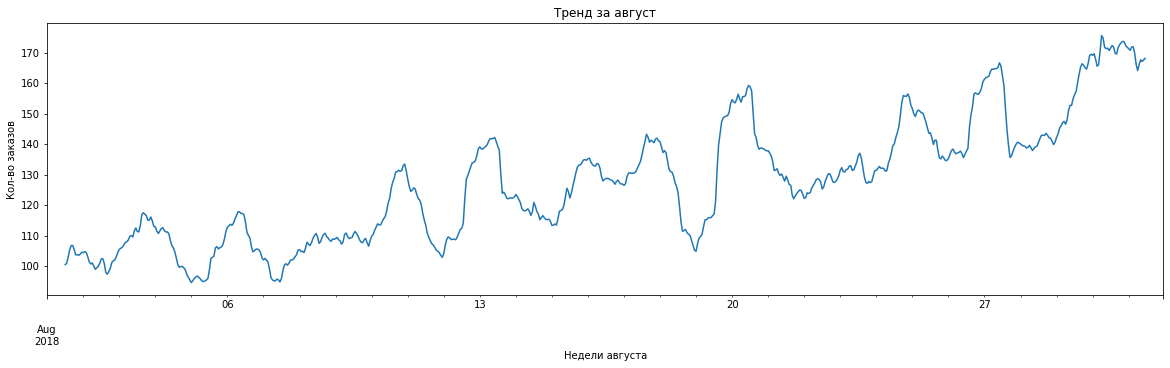

In [ ]:
decomposed_aug.trend.plot(figsize=figsize)
plt.title('Тренд за август')
plt.xlabel('Недели августа')
plt.ylabel('Кол-во заказов')
plt.show()

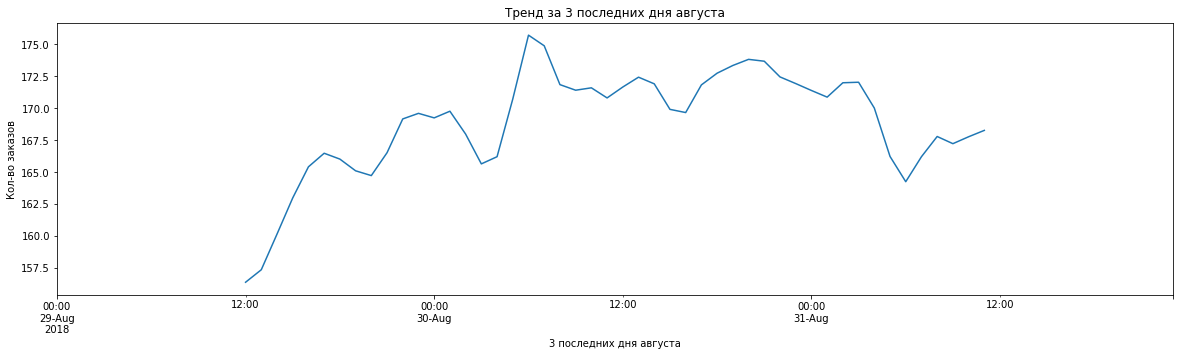

In [ ]:
decomposed_aug_3days.trend.plot(figsize=figsize)
plt.title('Тренд за 3 последних дня августа')
plt.xlabel('3 последних дня августа')
plt.ylabel('Кол-во заказов')
plt.show()

**Сезонность: весь период, последний месяц, последние 3 дня**

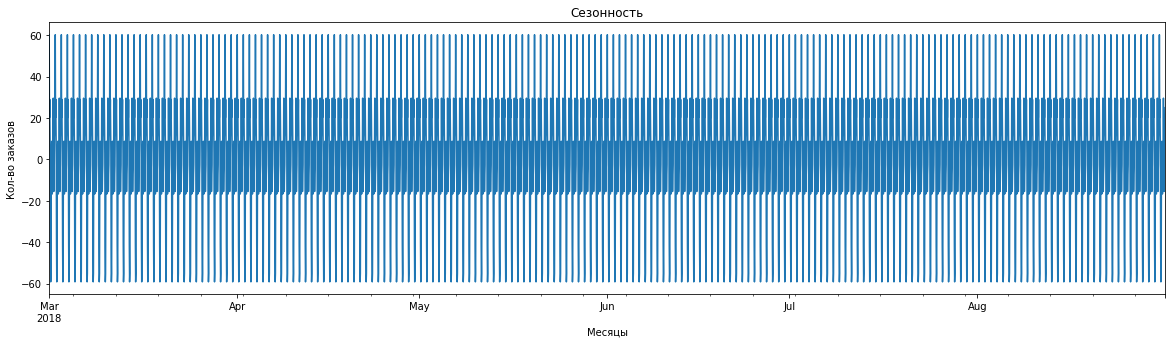

In [ ]:
decomposed.seasonal.plot(figsize=figsize)
plt.title('Сезонность')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

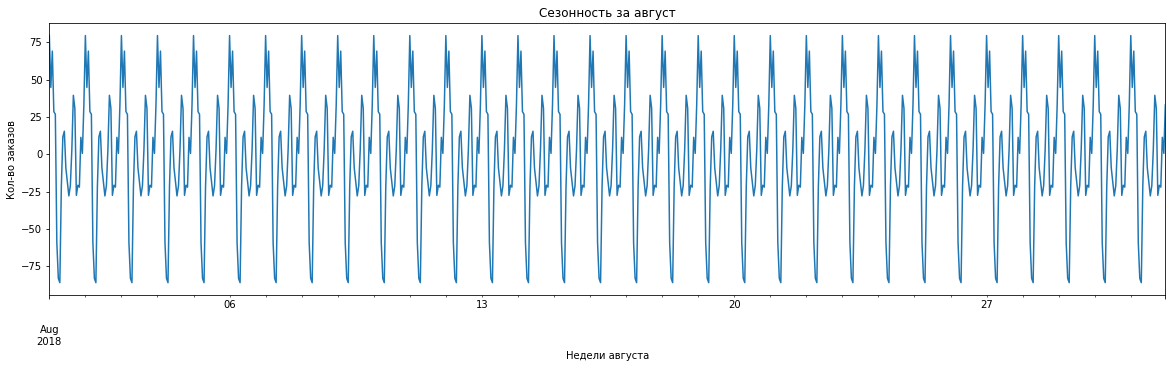

In [ ]:
decomposed_aug.seasonal.plot(figsize=figsize)
plt.title('Сезонность за август')
plt.xlabel('Недели августа')
plt.ylabel('Кол-во заказов')
plt.show()

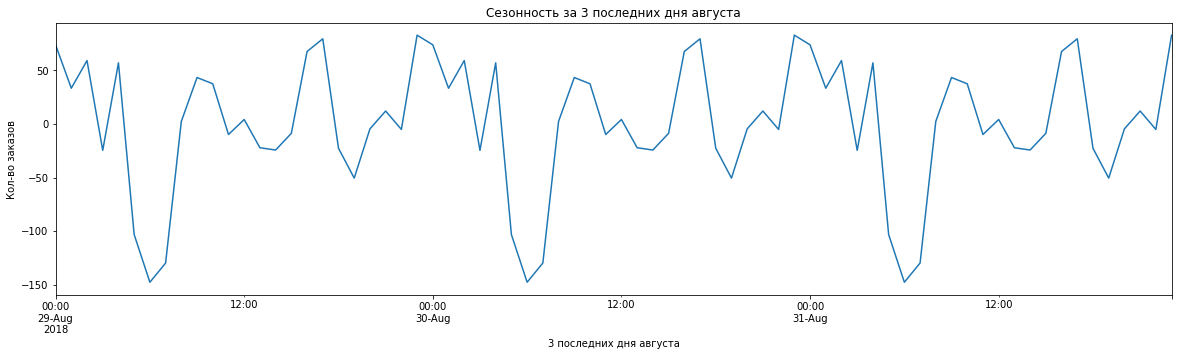

In [ ]:
decomposed_aug_3days.seasonal.plot(figsize=figsize)
plt.title('Сезонность за 3 последних дня августа')
plt.xlabel('3 последних дня августа')
plt.ylabel('Кол-во заказов')
plt.show()

**Промежуточный вывод:**

Сезонность явно сутки, так как на графике за 3 дня видно, что на всех 3 днях:

- падение заказов и минимум в районе 06:00 и 18:00
- рост заказов и максимум в районе 09:00 и 00:00


Добавим признаки "лаги" и "скользящее среднее" для столбца "num_orders".

In [ ]:
df['rolling_mean'] = df['num_orders'].shift().rolling(window=10).mean()
for lag in range(1, 25):
    df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

df.dropna(inplace=True)

display(df.head(5))

,num_orders,rolling_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,61.7,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-02 01:00:00,120,65.9,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-02 02:00:00,75,71.3,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-02 03:00:00,64,74.5,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-02 04:00:00,20,76.5,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0


## Обучение

In [ ]:
# Разделим данные на обучающую и тестовую выборки (10% от общего числа записей):
train = df.drop('num_orders', axis=1)
test = df['num_orders']

features_train, features_test, target_train, target_test  = train_test_split(train, test, shuffle=False, test_size=0.1)

Определим пять моделей для обучения: Линейная регрессия, Дерево решений, Случайный лес, LightGBMRegressor и CatBoost. Для каждой модели определим гиперпараметры и обучим модель на обучающей выборке.

In [ ]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

CPU times: user 10.5 ms, sys: 869 µs, total: 11.4 ms
Wall time: 4.48 ms


LinearRegression()

In [ ]:
%%time

model_dt = DecisionTreeRegressor(max_depth=5, min_samples_leaf=6, min_samples_split=16, random_state=42)
model_dt.fit(features_train, target_train)

CPU times: user 45.1 ms, sys: 0 ns, total: 45.1 ms
Wall time: 43.6 ms


DecisionTreeRegressor(max_depth=10, min_samples_leaf=10, random_state=42)

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

params = {'n_estimators': [50, 100, 200],
          'max_depth': [5, 10, 15]}

rf = RandomForestRegressor(random_state=42)

#grid_search = GridSearchCV(rf, params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

tscv = TimeSeriesSplit(n_splits=3)
grid_search = GridSearchCV(rf, params, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')

grid_search.fit(features_train, target_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(best_params)
print(best_score)

{'max_depth': 15, 'n_estimators': 100}
-762.9446074861213
CPU times: user 51.4 s, sys: 204 ms, total: 51.6 s
Wall time: 51.8 s


In [ ]:
%%time

model_rf = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
model_rf.fit(features_train, target_train)

CPU times: user 8.12 s, sys: 40 ms, total: 8.16 s
Wall time: 8.17 s


RandomForestRegressor(max_depth=15, n_estimators=200, random_state=42)

In [ ]:
%%time

from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

lgbm = LGBMRegressor(random_state=42)

params = {'n_estimators': [50, 100, 200],
          'max_depth': [5, 10, 15],
          'learning_rate': [0.01, 0.1, 0.5]}

#grid_search = GridSearchCV(lgbm, params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

tscv = TimeSeriesSplit(n_splits=3)
grid_search = GridSearchCV(lgbm, params, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')

grid_search.fit(features_train, target_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(best_params)
print(best_score)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
-747.3325621890277
CPU times: user 1min 10s, sys: 1.71 s, total: 1min 11s
Wall time: 1min 12s


In [ ]:
%%time

model_lgbm = LGBMRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model_lgbm.fit(features_train, target_train)

CPU times: user 684 ms, sys: 18.7 ms, total: 703 ms
Wall time: 783 ms


LGBMRegressor(max_depth=5, random_state=42)

In [ ]:
%%time

from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

cat = CatBoostRegressor(random_seed=42, silent=True)

params = {'iterations': [50, 100, 200],
          'depth': [5, 10, 15],
          'learning_rate': uniform(0.01, 0.5)}

#random_search = RandomizedSearchCV(cat, param_distributions=params, n_iter=10, cv=3, n_jobs=-1,
#                                   scoring='neg_mean_squared_error', random_state=42)

tscv = TimeSeriesSplit(n_splits=3)
random_search = RandomizedSearchCV(cat, param_distributions=params, n_iter=10, cv=tscv, n_jobs=-1,
                                   scoring='neg_mean_squared_error', random_state=42)

random_search.fit(features_train, target_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(best_params)
print(best_score)

{'depth': 5, 'iterations': 50, 'learning_rate': 0.16212112147976887}
-756.719925628052
CPU times: user 27min 6s, sys: 18min 54s, total: 46min
Wall time: 46min 34s


In [ ]:
%%time

model_cat = CatBoostRegressor(iterations=50, depth=5, learning_rate=0.16, random_seed=42)
model_cat.fit(features_train, target_train, verbose=False)

CPU times: user 181 ms, sys: 8.94 ms, total: 190 ms
Wall time: 695 ms


Определил наилучшие гиперпараметры для каждой модели, произвел обучение моделей по полученным гиперпараметрам

## Тестирование

Сделаем предсказания на тестовой выборке и рассчитаем значение метрики RMSE для каждой модели.

In [ ]:
predict_lr = model_lr.predict(features_test)
rmse_lr = mean_squared_error(target_test, predict_lr)**0.5
print("RMSE Линейной регрессии на тестовой выборке:", round(rmse_lr,2))

predict_dt = model_dt.predict(features_test)
rmse_dt = mean_squared_error(target_test, predict_dt)**0.5
print("RMSE Дерева решений на тестовой выборке:", round(rmse_dt,2))

predict_rf = model_rf.predict(features_test)
rmse_rf = mean_squared_error(target_test, predict_rf)**0.5
print("RMSE Случайного леса на тестовой выборке:", round(rmse_rf,2))

predict_lgbm = model_lgbm.predict(features_test)
rmse_lgbm = mean_squared_error(target_test, predict_lgbm)**0.5
print("RMSE LGBMRegressor на тестовой выборке:", round(rmse_lgbm,2))

predict_cat = model_cat.predict(features_test)
rmse_cat = mean_squared_error(target_test, predict_cat)**0.5
print("RMSE CatBoost на тестовой выборке:", round(rmse_cat,2))

RMSE Линейной регрессии на тестовой выборке: 45.06
RMSE Дерева решений на тестовой выборке: 56.41
RMSE Случайного леса на тестовой выборке: 42.8
RMSE LGBMRegressor на тестовой выборке: 41.67
RMSE CatBoost на тестовой выборке: 44.31


## Вывод

В рамках проекта были загруженны данные и сделан их анализ .

Было обучено 5 моделей, результат работы 4 из них соответсвуют ожиданиям заказчика.

Лучший результат показа модель LGBMRegressor с значением RMSE на тестовой выборке (10%) - 41.67